## Load the Data

In [1]:
import numpy as np
import pandas as pd

# Load the cleaned data from csv file
df_bank = pd.read_csv('./data_cleaned.csv', index_col=0)
df_bank.head(3)

,age,job,marital,education,credit_default,housing_loan,personal_loan,contact,last_contact_month,last_contact_day,...,campaign_contact_times,days_from_last_contact,previous_campaign_contact,previous_campaign_outcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3m_rate,num_of_employees,y
0,56,housemaid,married,basic.4y,no,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,1,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [2]:
df_bank.shape

(40098, 21)

In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40098 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        40098 non-null  int64  
 1   job                        40098 non-null  object 
 2   marital                    40098 non-null  object 
 3   education                  40098 non-null  object 
 4   credit_default             40098 non-null  object 
 5   housing_loan               40098 non-null  int64  
 6   personal_loan              40098 non-null  int64  
 7   contact                    40098 non-null  object 
 8   last_contact_month         40098 non-null  object 
 9   last_contact_day           40098 non-null  object 
 10  last_contact_duration      40098 non-null  int64  
 11  campaign_contact_times     40098 non-null  int64  
 12  days_from_last_contact     40098 non-null  int64  
 13  previous_campaign_contact  40098 non-null  int

## Data Preprocessing

### 1. Encoding categorical features

In [4]:
# Before any further processing, firstly I need to dummy code all categorical columns to make them into features that 
# only contain numerical binary values. This is to make sure the data can be used for machine learning models later.

In [5]:
# Four different ways of encoding categorical features:
# - LabelEncoder 
# - OneHotEncoder
# - DictVectorizer
# - Pandas get_dummies

# - LabelEncoder outputs a dataframe type. However if the categorical feature is multi class, LabelEncoder will return 
#   different values for different classes. This can lead to poor performance in modeling.
# - OneHotEncoder outputs a numpy array. For each class under a categorical feature, a new column is created for it.
# - DictVectorizer is a one step method to encode and support sparse matrix output. But the input need to be converted
#   to a dictionary first, and the final output is a numpy array. If the number of categorical features are huge, 
#   DictVectorizer will be a good choice as it supports sparse matrix output
# - Pandas get dummies method is a straight forward and easy way to encode categorical features. The output will 
#   remain dataframe type.

In [6]:
# I will use pandas get dummies to encode the categorical features as it is much straitforward than other ways. And 
# the output remains dataframe type make it easier to check what features I have got after encoding.

# Create a list for object type columns
categorical_columns = df_bank.columns[df_bank.dtypes==object].tolist()

# Write a for loop to convert categorical columns to dummy coded columns, and then attach the dummies to the dataset
df_bank_encoded=df_bank
for col in categorical_columns:
    col_dummy = pd.get_dummies(df_bank[col], prefix=col)
    df_bank_encoded = pd.concat([df_bank_encoded, col_dummy], axis=1)

# Drop the original object type columns from the dataframe
for col in categorical_columns:
    df_bank_encoded.drop(col, axis=1, inplace=True)

# Check the structure of the dataframe after encoding
df_bank_encoded.shape

(40098, 57)

### 2. Standardization

In [7]:
# Define a function to standardize the continuous data

from sklearn.preprocessing import StandardScaler

def stad_scaler(df):

    # Firstly, define a list of columns that only contains the continuous numerical columns that I would like to 
    # standardize, and a list of binary columns that I want to avoid standardizing.
    continuous_cols = df.columns[df.nunique()>2].tolist()   
    binary_cols= df.columns[df.nunique()<3].tolist()
    binary_cols.remove('y')
    
    # Initialize the StandardScaler
    ss = StandardScaler()
    
    # Fit and transform the continuous columns
    X_scaled = pd.DataFrame(ss.fit_transform(df[continuous_cols]), columns=continuous_cols, index=df.index)
    X_not_scaled= df[binary_cols]
    
    # Combine the scaled dataframe and the unscaled one
    X_stad = pd.concat([X_scaled, X_not_scaled], axis=1)
    
    return X_stad


### 3. Define target y and variables X

In [8]:
# X, y without Standardization

y = df_bank_encoded['y'].values # The target is the 'y' column
X = df_bank_encoded.drop('y', axis=1) # The variables X

In [9]:
# X, y with Standardization

y = df_bank_encoded['y'].values # The target is the 'y' column
X_stad = stad_scaler(df_bank_encoded) # The standardized variables X

### 4. Split the data into training set and testing set with stratified

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# train test split for the data without standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42,stratify=y)

In [12]:
# train test split for the data with standardization
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_stad, y, train_size=0.75, test_size=0.25, 
                                                        random_state=42, stratify=y)

### 5. Over-sampling for imbalance data

In [13]:
# As the data is imbalanced (11% of 'yes' and 89% of 'no' in the target 'y'), I would use Oversampling techniques to 
# preprocess the data for training the machine learning models purpose.

from imblearn.over_sampling import SMOTE, ADASYN

In [14]:
# SMOTE
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

# ADASYN
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train, y_train)

In [15]:
# SMOTE with standardized data
Xs_train_smote, ys_train_smote = SMOTE().fit_resample(Xs_train, ys_train)

# ADASYN with standardized data
Xs_train_adasyn, ys_train_adasyn = ADASYN().fit_resample(Xs_train, ys_train)

## Machine Learning Models

##### The Following machine learning models will be used to classify the target
- K-Nearest Neighbors
- Logistic Regression
- Support Vector Machine
- Decision Tree
- RandomForestClassifier
- GradientBoostingClassifier
- AdaBoostClassifier
- VotingClassifier(Hard Voting/Soft Voting)

### 1. Overview of Metrics

#### 1.1 Baseline Accuracy
Firstly calculate the baseline accuracy of the classification

In [16]:
# Baseline accuracy = majority_class_n / total_n
baseline_accuracy = '{0:.2f}%'.format(len(df_bank_encoded[df_bank_encoded['y']==0]) / len(df_bank_encoded['y']) *100)
print('The Baseline Accuracy:', baseline_accuracy)

The Baseline Accuracy: 88.74%


#### 1.2 Metrics that matter for the classification of this dataset
- Maximize the recall/True Positive Rate (find out as many as the clients that will actually subscribe the product)
- Lower False Positive Rate or Higher Precision
- If we want to create a balanced classification model with the optimal balance of recall and precision, then we try to maximize the F1 score
- ROC and AUC (higher number indicating better classification performance)

### 2. Overview of base models

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.pipeline import make_pipeline


In [18]:
# KNN
Base_knn = KNeighborsClassifier()
Base_knn.fit(X_train, y_train)
pred_knn = Base_knn.predict(X_test)
print('Base KNN accuracy:', accuracy_score(y_test, pred_knn))
print('Base KNN AUC:', roc_auc_score(y_test, pred_knn))
print('--------------------------------------------------')

# LogisticRegression
Base_lr = LogisticRegression(max_iter=2000)
Base_lr.fit(X_train, y_train)
pred_lr = Base_lr.predict(X_test)
print('Base LogisticRegression accuracy:', accuracy_score(y_test, pred_lr))
print('Base LogisticRegression AUC:', roc_auc_score(y_test, pred_lr))
print('--------------------------------------------------')

# SVM
Base_svm = svm.SVC(kernel='linear')
Base_svm.fit(X_train, y_train)
pred_svm = Base_svm.predict(X_test)
print('Base SVM accuracy:', accuracy_score(y_test, pred_svm))
print('Base SVM AUC:', roc_auc_score(y_test, pred_svm))
print('--------------------------------------------------')

# DecisionTree
Base_dt = DecisionTreeClassifier()
Base_dt.fit(X_train, y_train)
pred_dt = Base_dt.predict(X_test)
print('Base DecisionTree accuracy:', accuracy_score(y_test, pred_dt))
print('Base DecisionTree AUC:', roc_auc_score(y_test, pred_dt))
print('--------------------------------------------------')

# RandomForest
Base_rf = RandomForestClassifier()
Base_rf.fit(X_train, y_train
pred_rf = Base_rf.predict(X_test)
print('Base RandomForest accuracy:', accuracy_score(y_test, pred_rf))
print('Base RandomForest AUC:', roc_auc_score(y_test, pred_rf))
print('--------------------------------------------------')

# GradientBoostingClassifier
Base_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
Base_gbc.fit(X_train, y_train)
pred_gbc = Base_gbc.predict(X_test)
print('Base GradientBoosting accuracy:', accuracy_score(y_test, pred_gbc))
print('Base GradientBoosting AUC:', roc_auc_score(y_test, pred_gbc))
print('--------------------------------------------------')

# AdaBoostClassifier
Base_ada = AdaBoostClassifier(n_estimators=100)
Base_ada.fit(X_train, y_train)
pred_ada = Base_ada.predict(X_test)
print('Base AdaBoost accuracy:', accuracy_score(y_test, pred_ada))
print('Base AdaBoost AUC:', roc_auc_score(y_test, pred_ada))


Base KNN accuracy: 0.9056359102244389
Base KNN AUC: 0.7283644463968241
--------------------------------------------------
Base LogisticRegression accuracy: 0.912718204488778
Base LogisticRegression AUC: 0.707608459291026
--------------------------------------------------
Base SVM accuracy: 0.8692269326683292
Base SVM AUC: 0.7151962387131924
--------------------------------------------------
Base DecisionTree accuracy: 0.8869825436408978
Base DecisionTree AUC: 0.7321607008016262
--------------------------------------------------
Base RandomForest accuracy: 0.9144139650872818
Base RandomForest AUC: 0.7271238533973529
--------------------------------------------------
Base GradientBoosting accuracy: 0.9163092269326684
Base GradientBoosting AUC: 0.7339917204854364
--------------------------------------------------
Base AdaBoost accuracy: 0.9154114713216958
Base AdaBoost AUC: 0.7098993247828663


In [19]:
# How the models perform with the data preprocessed by SMOTE?

# KNN
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_smote, y_train_smote)
pred_knn = model_knn.predict(X_test)
print('KNN accuracy:', accuracy_score(y_test, pred_knn))
print('KNN AUC:', roc_auc_score(y_test, pred_knn))
print('--------------------------------------------------')

# LogisticRegression
model_lr = LogisticRegression(max_iter=2000)
model_lr.fit(X_train_smote, y_train_smote)
pred_lr = model_lr.predict(X_test)
print('LogisticRegression accuracy:', accuracy_score(y_test, pred_lr))
print('LogisticRegression AUC:', roc_auc_score(y_test, pred_lr))
print('--------------------------------------------------')

# SVM
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train_smote, y_train_smote)
pred_svm = model_svm.predict(X_test)
print('SVM accuracy:', accuracy_score(y_test, pred_svm))
print('SVM AUC:', roc_auc_score(y_test, pred_svm))
print('--------------------------------------------------')

# DecisionTree
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_smote, y_train_smote)
pred_dt = model_dt.predict(X_test)
print('DecisionTree accuracy:', accuracy_score(y_test, pred_dt))
print('DecisionTree AUC:', roc_auc_score(y_test, pred_dt))
print('--------------------------------------------------')

# RandomForest
model_rf = RandomForestClassifier()
model_rf.fit(X_train_smote, y_train_smote)
pred_rf = model_rf.predict(X_test)
print('RandomForest accuracy:', accuracy_score(y_test, pred_rf))
print('RandomForest AUC:', roc_auc_score(y_test, pred_rf))
print('--------------------------------------------------')

# GradientBoostingClassifier
model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_gbc.fit(X_train_smote, y_train_smote)
pred_gbc = model_gbc.predict(X_test)
print('GradientBoosting accuracy:', accuracy_score(y_test, pred_gbc))
print('GradientBoosting AUC:', roc_auc_score(y_test, pred_gbc))
print('--------------------------------------------------')

# AdaBoostClassifier
model_ada = AdaBoostClassifier(n_estimators=100)
model_ada.fit(X_train_smote, y_train_smote)
pred_ada = model_ada.predict(X_test)
print('AdaBoost accuracy:', accuracy_score(y_test, pred_ada))
print('AdaBoost AUC:', roc_auc_score(y_test, pred_ada))

KNN accuracy: 0.8516708229426434
KNN AUC: 0.83251685852381
--------------------------------------------------


/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression accuracy: 0.9087281795511222
LogisticRegression AUC: 0.7270134844294627
--------------------------------------------------
SVM accuracy: 0.9024438902743143
SVM AUC: 0.6848060911324085
--------------------------------------------------
DecisionTree accuracy: 0.8859850374064838
DecisionTree AUC: 0.7343053037640747
--------------------------------------------------
RandomForest accuracy: 0.9141147132169576
RandomForest AUC: 0.762528396237837
--------------------------------------------------
GradientBoosting accuracy: 0.9120199501246883
GradientBoosting AUC: 0.7509081419541072
--------------------------------------------------
AdaBoost accuracy: 0.9132169576059851
AdaBoost AUC: 0.7395959948161931


In [20]:
# What if preprocess the data with both StandardScaler and SMOTE?

# KNN
model_knn = KNeighborsClassifier()
model_knn.fit(Xs_train_smote, ys_train_smote)
pred_knn = model_knn.predict(Xs_test)
print('KNN accuracy:', accuracy_score(ys_test, pred_knn))
print('KNN AUC:', roc_auc_score(ys_test, pred_knn))
print('--------------------------------------------------')

# LogisticRegression
model_lr = LogisticRegression(max_iter=3000)
model_lr.fit(Xs_train_smote, ys_train_smote)
pred_lr = model_lr.predict(Xs_test)
print('LogisticRegression accuracy:', accuracy_score(ys_test, pred_lr))
print('LogisticRegression AUC:', roc_auc_score(ys_test, pred_lr))
print('--------------------------------------------------')

# SVM
model_svm = svm.SVC(kernel='linear')
model_svm.fit(Xs_train_smote, ys_train_smote)
pred_svm = model_svm.predict(Xs_test)
print('SVM accuracy:', accuracy_score(ys_test, pred_svm))
print('SVM AUC:', roc_auc_score(ys_test, pred_svm))
print('--------------------------------------------------')

# DecisionTree
model_dt = DecisionTreeClassifier()
model_dt.fit(Xs_train_smote, ys_train_smote)
pred_dt = model_dt.predict(Xs_test)
print('DecisionTree accuracy:', accuracy_score(ys_test, pred_dt))
print('DecisionTree AUC:', roc_auc_score(ys_test, pred_dt))
print('--------------------------------------------------')

# RandomForest
model_rf = RandomForestClassifier()
model_rf.fit(Xs_train_smote, ys_train_smote)
pred_rf = model_rf.predict(Xs_test)
print('RandomForest accuracy:', accuracy_score(ys_test, pred_rf))
print('RandomForest AUC:', roc_auc_score(ys_test, pred_rf))
print('--------------------------------------------------')

# GradientBoostingClassifier
model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_gbc.fit(Xs_train_smote, ys_train_smote)
pred_gbc = model_gbc.predict(Xs_test)
print('GradientBoosting accuracy:', accuracy_score(ys_test, pred_gbc))
print('GradientBoosting AUC:', roc_auc_score(ys_test, pred_gbc))
print('--------------------------------------------------')

# AdaBoostClassifier
model_ada = AdaBoostClassifier(n_estimators=100)
model_ada.fit(Xs_train_smote, ys_train_smote)
pred_ada = model_ada.predict(Xs_test)
print('AdaBoost accuracy:', accuracy_score(ys_test, pred_ada))
print('AdaBoost AUC:', roc_auc_score(ys_test, pred_ada))

KNN accuracy: 0.85785536159601
KNN AUC: 0.8468281840426684
--------------------------------------------------
LogisticRegression accuracy: 0.9111221945137157
LogisticRegression AUC: 0.7708955289267256
--------------------------------------------------
SVM accuracy: 0.9110224438902743
SVM AUC: 0.7685193353289026
--------------------------------------------------
DecisionTree accuracy: 0.8831920199501246
DecisionTree AUC: 0.7640514083418827
--------------------------------------------------
RandomForest accuracy: 0.9078304239401497
RandomForest AUC: 0.8100272273323946
--------------------------------------------------
GradientBoosting accuracy: 0.9021446384039901
GradientBoosting AUC: 0.8133968412072822
--------------------------------------------------
AdaBoost accuracy: 0.9010473815461346
AdaBoost AUC: 0.8023386372832647


In [21]:
# Make a dataframe to compare the performance of the base models
base_auc = pd.DataFrame([[0.73, 0.84, 0.84], [0.71, 0.72, 0.77], [0.72, 0.68, 0.77],
                        [0.73, 0.73, 0.76],[0.74, 0.75, 0.81], [0.73, 0.74, 0.81],
                       [0.71, 0.74, 0.79]], 
                       index=['KNN','LogisticRegression','SVM','DecisionTree','RandomForest','GradientBoosting','AdaBoost'],
                      columns=['No_preprocessing','SMOTE','Standardize+SMOTE'])
base_auc

,No_preprocessing,SMOTE,Standardize+SMOTE
KNN,0.73,0.84,0.84
LogisticRegression,0.71,0.72,0.77
SVM,0.72,0.68,0.77
DecisionTree,0.73,0.73,0.76
RandomForest,0.74,0.75,0.81
GradientBoosting,0.73,0.74,0.81
AdaBoost,0.71,0.74,0.79


In [22]:
# - With SMOTE, most of the models' AUC rate improved (except svm). This means SMOTE works well in this case for my goal.
#   I also tried ADASYN, and it worked very similar with SMOTE did.
# - With both standardizing the data and using SMOTE handling imbalance data, most of the models perform better
#   This means standardizing the data also works.
# - I will use the models that built with standardization and SMOTE as base models for further optimazation.

In [23]:
# From the overview above, we can see that the KNN and tree based ensembles models outperformed other models. But we can not
# draw a conclusion yet. Let have a further exploration of each individual model.

### 3. Boosting models' performance with feature engineering and optimazation
- Feature engineering might include the following:
    - Oversampling minority class
    - Correlated variables
    - Near Zero Variance
    - Principal component analysis (PCA)
    - Linear discriminant analysis (LDA)
- Optimazation might include the following:
    - Stochastic Gradient Descent
    - Adam: Adaptive Moment Gradient Descent
    - GridSearchCV
    - Set stoppimg criterions for decision trees

### 3.1 K-Nearest Neighbors

#### 3.1.1 Base KNN model (Preprocessing: Standardize+SMOTE)

In [24]:
# Print the performance of the base KNN model so that I can use it for comparison later.
model_knn = KNeighborsClassifier()
model_knn.fit(Xs_train_smote, ys_train_smote)
pred_knn = model_knn.predict(Xs_test)

print('KNN AUC:', roc_auc_score(ys_test, pred_knn))
print(classification_report(ys_test, pred_knn))

KNN AUC: 0.8430739465115241
              precision    recall  f1-score   support

           0       0.97      0.86      0.92      8896
           1       0.43      0.82      0.57      1129

    accuracy                           0.86     10025
   macro avg       0.70      0.84      0.74     10025
weighted avg       0.91      0.86      0.88     10025



#### 3.1.2 KNN + VarianceThreshold

In [25]:
from sklearn.feature_selection import VarianceThreshold

# Make a pipeline and fit the model
pipe_knn_VarThre = make_pipeline(VarianceThreshold(0.08), model_knn)
pipe_knn_VarThre.fit(Xs_train_smote, ys_train_smote)
pred_knn_VarThre = pipe_knn_VarThre.predict(Xs_test)

print('KNN AUC:', roc_auc_score(ys_test, pred_knn_VarThre))
print(classification_report(ys_test, pred_knn_VarThre))

KNN AUC: 0.8346932728396557
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8896
           1       0.43      0.80      0.56      1129

    accuracy                           0.86     10025
   macro avg       0.70      0.83      0.74     10025
weighted avg       0.91      0.86      0.88     10025



In [26]:
# Check how many features eliminated and retained by VarianceThresholds
selector = VarianceThreshold(0.08)
selector.fit(Xs_train_smote)
np.unique(selector.get_support(), return_counts=True)

(array([False,  True]), array([18, 38]))

In [27]:
# With a VarianceThreshold of 0.08 (18 features removed, and 38 features retained), the classification accuracy is 
# almost the same with the original one (also tried other threshold). It looks Removing low variance variables does 
# not help.

# Actually, base on my analysis in EDA, I don't actually have variable that near zero variance variable in the dataset.

#### 3.1.3 KNN + SelectKBest

In [28]:
from sklearn.feature_selection import SelectKBest

# Make a pipeline and fit the model
pipe_knn_SelectKB = make_pipeline(SelectKBest(k=40), model_knn)
pipe_knn_SelectKB.fit(Xs_train_smote, ys_train_smote)
pred_knn_SelectKB = pipe_knn_SelectKB.predict(Xs_test)

print('KNN AUC:', roc_auc_score(ys_test, pred_knn_SelectKB))
print(classification_report(ys_test, pred_knn_SelectKB))

KNN AUC: 0.8407810399156318
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8896
           1       0.44      0.81      0.57      1129

    accuracy                           0.86     10025
   macro avg       0.71      0.84      0.74     10025
weighted avg       0.91      0.86      0.88     10025



In [29]:
# Again, using SelectKBest to select the best 40 features (also try 30 and 50) doesn't seem to improve the performance

#### 3.1.4 KNN + PCA 

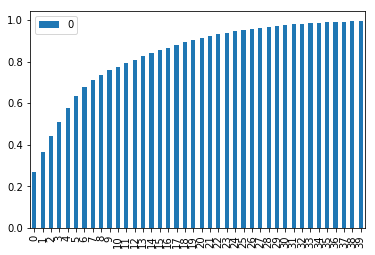

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(X_stad)
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot.bar()

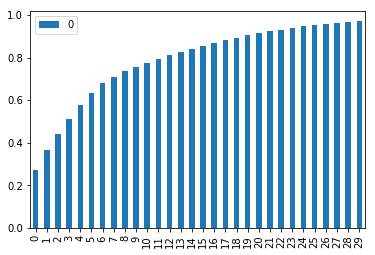

In [31]:
pca = PCA(n_components=30)
pca.fit(X_stad)
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot.bar()

In [32]:
pca.explained_variance_ratio_.sum()

0.9719384963623497

In [33]:
# Make a pipeline and fit the model
pipe_knn_pca = make_pipeline(PCA(n_components=40), model_knn)
pipe_knn_pca.fit(Xs_train_smote, ys_train_smote)
pred_knn_pca = pipe_knn_pca.predict(Xs_test)

print('KNN AUC:', roc_auc_score(ys_test, pred_knn_pca))
print(classification_report(ys_test, pred_knn_pca))

KNN AUC: 0.8473157589959919
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8896
           1       0.42      0.84      0.56      1129

    accuracy                           0.85     10025
   macro avg       0.70      0.85      0.74     10025
weighted avg       0.91      0.85      0.87     10025



In [34]:
# With a pca(n_components=40)(also try n_components 20, 25, 30, 50), there is no obvious change in model's performance.

#### 3.1.4 KNN + GridSearchCV

In [44]:
from sklearn.model_selection import GridSearchCV
knn_params = {
    'n_neighbors':[3, 5, 8, 12, 16],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan'],
    'algorithm':['auto', 'ball_tree', 'kd_tree']
}
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1)
knn_gridsearch.fit(Xs_train_smote, ys_train_smote)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 240.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 8, 12, 16],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [45]:
# Print out the set of hyperparameters that achieved the best score.
print(knn_gridsearch.best_params_)

# Print out the best score found in the search
print(knn_gridsearch.best_score_)


{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
0.9391231028667791


In [46]:
knn_gridsearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [49]:
# Use the best estimator to make prediction
# knn_gridsearch.best_estimator_
best_estimator = knn_gridsearch.best_estimator_
best_estimator.fit(Xs_train_smote, ys_train_smote)
y_pred = best_estimator.predict(Xs_test)

# Classification Report
print('KNN+GridSearch AUC:', roc_auc_score(ys_test, y_pred))
print(classification_report(ys_test, y_pred))

KNN+GridSearch AUC: 0.798799113941796
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      8896
           1       0.46      0.70      0.55      1129

    accuracy                           0.87     10025
   macro avg       0.71      0.80      0.74     10025
weighted avg       0.90      0.87      0.88     10025



In [35]:
# The estimator from GridSearch does not perform better.

In [36]:
# For KNN model, the chosen feature engineering and hyperparameters tuning does not seem work well. 
# The base KNN model will be chosen as a candidate for the classification task.

### 3.2 Logistic Regression

#### 3.2.1 Base Logistic Regression model (Preprocessing: Standardize+SMOTE)

In [37]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(Xs_train_smote, ys_train_smote)
pred_lr = model_lr.predict(Xs_test)

print('LogisticRegression AUC:', roc_auc_score(ys_test, pred_lr))
print(classification_report(ys_test, pred_lr))

LogisticRegression AUC: 0.772118498735113
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8896
           1       0.61      0.59      0.60      1129

    accuracy                           0.91     10025
   macro avg       0.78      0.77      0.78     10025
weighted avg       0.91      0.91      0.91     10025



#### 3.2.2 Logistic Regression + Univirate feature selection

In [38]:
# SelectFwe
from sklearn.feature_selection import SelectFwe
model_lr = LogisticRegression(max_iter=500)
# Make a pipeline that include the feature selection and the model
pipe_lr_SelectFwe = make_pipeline(SelectFwe(), model_lr)
# Fit the model and make prediction
pipe_lr_SelectFwe.fit(Xs_train_smote, ys_train_smote)
pred_lr_SelectFwe = pipe_lr_SelectFwe.predict(Xs_test)
# Print the performance of the classification
print('lr+smote+SelectFwe AUC:', roc_auc_score(ys_test, pred_lr_SelectFwe))
print(classification_report(ys_test, pred_lr_SelectFwe))

lr+smote+SelectFwe AUC: 0.7843455085355985
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8896
           1       0.59      0.62      0.61      1129

    accuracy                           0.91     10025
   macro avg       0.77      0.78      0.78     10025
weighted avg       0.91      0.91      0.91     10025



In [39]:
# From the result, SelectFwe slightly imporved the recall and AUC. 
# Using SelectFpr and SelcetFdr got exactly the same result.

#### 3.2.3 Logistic Regression + RFECV

In [40]:
# RFECV
from sklearn.feature_selection import RFECV
model_lr = LogisticRegression(max_iter=500)
pipe_lr_RFECV = make_pipeline(RFECV(estimator=model_lr, scoring="roc_auc"), model_lr)
pipe_lr_RFECV.fit(Xs_train_smote, ys_train_smote)
pred_lr_RFECV = pipe_lr_RFECV.predict(Xs_test)

print('lr+smote+RFECV AUC:', roc_auc_score(ys_test, pred_lr_RFECV))
print(classification_report(ys_test, pred_lr_RFECV))

lr+smote+RFECV AUC: 0.7750499722011583
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8896
           1       0.61      0.60      0.61      1129

    accuracy                           0.91     10025
   macro avg       0.78      0.78      0.78     10025
weighted avg       0.91      0.91      0.91     10025



In [41]:
# RFECV doesn't work better than SelecFwe for this dataset.

#### 3.2.4 Logistic Regression + pca + Removing correlated variables

In [42]:
# As there are perfectly or highly correlation exist among some variables, this can cause “Multicollinearity”.
# Logistic Regression are not immune to “Multicollinearity” problem. Then I will need to do some feature engineering

In [43]:
# PCA
from sklearn.decomposition import PCA
model_lr = LogisticRegression(max_iter=500)
pipe_lr_pca = make_pipeline(PCA(n_components=35), model_lr)
pipe_lr_pca.fit(Xs_train_smote, ys_train_smote)
pred_lr_pca = pipe_lr_pca.predict(Xs_test)

print('lr+smote+pca AUC:', roc_auc_score(ys_test, pred_lr_pca))
print(classification_report(ys_test, pred_lr_pca))

lr+smote+pca AUC: 0.8506954788250887
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8896
           1       0.47      0.82      0.60      1129

    accuracy                           0.88     10025
   macro avg       0.72      0.85      0.76     10025
weighted avg       0.92      0.88      0.89     10025



In [44]:
# By comparing the model with different feature selection stratigies, the best model so far is the one 
# using pca(n_components=35)

In [45]:
# What if I manually remove some of the variables that are perfectly or highly correlated to each other

y = df_bank_encoded['y'].values 
Xs2 = stad_scaler(df_bank_encoded.drop(['euribor_3m_rate', 'num_of_employees'], axis=1))
Xs2_train, Xs2_test, ys2_train, ys2_test = train_test_split(Xs2, y, train_size=0.75, test_size=0.25, 
                                                        random_state=42, stratify=y)
Xs2_train_smote, ys2_train_smote = SMOTE().fit_resample(Xs2_train, ys2_train)

model_lr = LogisticRegression(max_iter=500)
pipe_lr_pca_2 = make_pipeline(PCA(n_components=35), model_lr)
pipe_lr_pca_2.fit(Xs2_train_smote, ys2_train_smote)
pred_lr_pca_2 = pipe_lr_pca_2.predict(Xs2_test)

print('lr+smote+pca+remove_correlation accuracy:', accuracy_score(ys2_test, pred_lr_pca_2))
print('lr+smote+pca+remove_correlation AUC:', roc_auc_score(ys2_test, pred_lr_pca_2))
print(classification_report(ys2_test, pred_lr_pca_2))

lr+smote+pca+remove_correlation accuracy: 0.8711221945137158
lr+smote+pca+remove_correlation AUC: 0.8481168176619024
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8896
           1       0.46      0.82      0.59      1129

    accuracy                           0.87     10025
   macro avg       0.72      0.85      0.76     10025
weighted avg       0.92      0.87      0.89     10025



In [46]:
# Removing the two correlated variables doesn't seem to change the model performance

#### 3.2.5 Logistic Regression + GridSearchCV()

In [49]:
from sklearn.model_selection import GridSearchCV
lr_params = {
    'penalty':['l1','l2'],
    'C':[0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'class_weight': ['balanced'],
    'solver':['saga']
}
lr_gridsearch = GridSearchCV(LogisticRegression(max_iter=2000), lr_params, cv=5, verbose=1)
lr_gridsearch.fit(Xs_train_smote, ys_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 10.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
                         'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [51]:
# Print out the set of hyperparameters that achieved the best score.
print(lr_gridsearch.best_params_)

# Print out the best score found in the search
print(lr_gridsearch.best_score_)

# Print out the best estimator
print(lr_gridsearch.best_estimator_)

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.9211542064830429
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [55]:
# Use the best estimator to make prediction

best_lr = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
pipe_lr_gs = make_pipeline(PCA(n_components=35), best_lr)
pipe_lr_gs.fit(Xs_train_smote, ys_train_smote)
pred_lr_gs = pipe_lr_gs.predict(Xs_test)

print('lr+smote+pca+gridsearch AUC:', roc_auc_score(ys_test, pred_lr_gs))
print(classification_report(ys_test, pred_lr_gs))

lr+smote+pca+gridsearch AUC: 0.8516800875066113
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8896
           1       0.47      0.82      0.60      1129

    accuracy                           0.87     10025
   macro avg       0.72      0.85      0.76     10025
weighted avg       0.92      0.87      0.89     10025



In [66]:
# GridSearch with the pipeline (PCA+LogisticRegression)

plr = make_pipeline(PCA(n_components=35), LogisticRegression(max_iter=1000))

plr_params = {}
plr_params['logisticregression__penalty'] = ['l1','l2']
plr_params['logisticregression__C'] = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.8]
plr_params['logisticregression__class_weight'] = ['balanced']
plr_params['logisticregression__solver'] = ['saga']

plr_gridsearch = GridSearchCV(plr, plr_params, cv=5, verbose=1)
plr_gridsearch.fit(Xs_train_smote, ys_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   49.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=35, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000

In [67]:
# Print out the set of hyperparameters that achieved the best score.
print(plr_gridsearch.best_params_)

# Print out the best score found in the search
print(plr_gridsearch.best_score_)

# Print out the best estimator
print(plr_gridsearch.best_estimator_)

{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
0.8952782462057336
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=35,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [69]:
# Use the best estimator to make prediction

best_pipe = plr_gridsearch.best_estimator_
best_pipe.fit(Xs_train_smote, ys_train_smote)
pred_best_pipe = best_pipe.predict(Xs_test)

print(' lr pipe gridsearch AUC:', roc_auc_score(ys_test, pred_best_pipe))
print(classification_report(ys_test, pred_best_pipe))

 lr pipe gridsearch AUC: 0.8505695277701665
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8896
           1       0.46      0.82      0.59      1129

    accuracy                           0.87     10025
   macro avg       0.72      0.85      0.76     10025
weighted avg       0.92      0.87      0.89     10025



In [56]:
# The pipeline gridsearch got very similar performance with the lr model gridsearch did.
# GridSearchCV doesn't seem to help here.

In [58]:
# Make a dataframe to compare the performance of the models
compare = pd.DataFrame([[0.61,0.59,0.6,0.77], [0.59, 0.62, 0.61, 0.78], [0.61, 0.60, 0.61, 0.78],
                        [0.47, 0.82, 0.60, 0.85], [0.47, 0.82, 0.60, 0.85]], 
                       index=['Base','SelectFwe','RFECV','pca35','GridSearch'],
                      columns=['percision','recall','F1','AUC'])
compare

,percision,recall,F1,AUC
Base,0.61,0.59,0.60,0.77
SelectFwe,0.59,0.62,0.61,0.78
RFECV,0.61,0.60,0.61,0.78
pca35,0.47,0.82,0.60,0.85
GridSearch,0.47,0.82,0.60,0.85


In [59]:
# The Logistic Regression model with PCA(n_components=35) works well for this dataset. I will use this model as a
# canddidate for the classification.

### 3.3 SVM

##### 3.3.1 SVM base model

In [60]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(Xs_train_smote, ys_train_smote)
pred_svm = model_svm.predict(Xs_test)

print('SVM AUC:', roc_auc_score(ys_test, pred_svm))
print(classification_report(ys_test, pred_svm))

SVM AUC: 0.7725613685313929
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8896
           1       0.61      0.59      0.60      1129

    accuracy                           0.91     10025
   macro avg       0.78      0.77      0.78     10025
weighted avg       0.91      0.91      0.91     10025



#### 3.3.2 LinearSVC

In [61]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

In [184]:
# Make a pipeline that include MinMax scaler and LinearSVC

# Try loss='hinge' (LinearSVC works only when specific combination of params made)
model_lsvc = LinearSVC(loss='hinge', max_iter=2000)
pipe_lsvc = make_pipeline(MinMaxScaler(), model_lsvc)

lsvc_params = {}
#lsvc_params['MinMaxScaler'] = []
lsvc_params['linearsvc__penalty'] = ['l2']
lsvc_params['linearsvc__C'] = [0.001, 0.01, 0.1, 0.5, 1.0]
lsvc_params['linearsvc__dual'] = [True]

lsvc_gridsearch = GridSearchCV(pipe_lsvc, lsvc_params, cv=5, verbose=1)
lsvc_gridsearch.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('linearsvc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='hinge', max_iter=2000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_job

In [185]:
# Print out the set of hyperparameters that achieved the best score.
print(lsvc_gridsearch.best_params_)

# Print out the best score found in the search
print(lsvc_gridsearch.best_score_)

{'linearsvc__C': 0.1, 'linearsvc__dual': True, 'linearsvc__penalty': 'l2'}
0.9252951096121416


In [66]:
# Use the best estimator to make prediction

model_lsvc = LinearSVC(C=0.1, dual=True, loss='hinge', penalty='l2', max_iter=3000)
pipe_lsvc = make_pipeline(MinMaxScaler(), model_lsvc)
pipe_lsvc.fit(X_train_smote, y_train_smote)
pred_lsvc = pipe_lsvc.predict(X_test)

print('linearSVC+smote+gridsearch AUC:', roc_auc_score(y_test, pred_lsvc))
print(classification_report(y_test, pred_lsvc))

linearSVC+smote+gridsearch AUC: 0.6136394637611434
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8896
           1       0.65      0.24      0.36      1129

    accuracy                           0.90     10025
   macro avg       0.78      0.61      0.65     10025
weighted avg       0.88      0.90      0.88     10025



/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [187]:
# Try loss='squared_hinge'
model_lsvc = LinearSVC(loss='squared_hinge')
pipe_lsvc = make_pipeline(MinMaxScaler(), model_lsvc)

lsvc_params = {}
#lsvc_params['MinMaxScaler'] = []
lsvc_params['linearsvc__penalty'] = ['l2']
lsvc_params['linearsvc__C'] = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1.0]
lsvc_params['linearsvc__dual'] = [True, False]

lsvc_gridsearch = GridSearchCV(pipe_lsvc, lsvc_params, cv=5, verbose=1)
lsvc_gridsearch.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   24.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('linearsvc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                          

In [188]:
# Print out the set of hyperparameters that achieved the best score.
print(lsvc_gridsearch.best_params_)

# Print out the best score found in the search
print(lsvc_gridsearch.best_score_)

{'linearsvc__C': 0.01, 'linearsvc__dual': True, 'linearsvc__penalty': 'l2'}
0.9239460370994941


In [67]:
model_lsvc = LinearSVC(C=0.01, dual=True, loss='squared_hinge', penalty='l2', max_iter=3000)
pipe_lsvc = make_pipeline(MinMaxScaler(), model_lsvc)
pipe_lsvc.fit(X_train_smote, y_train_smote)
pred_lsvc = pipe_lsvc.predict(X_test)

print('linearSVC+smote+gridsearch AUC:', roc_auc_score(y_test, pred_lsvc))
print(classification_report(y_test, pred_lsvc))

linearSVC+smote+gridsearch AUC: 0.6518115943471972
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8896
           1       0.68      0.32      0.44      1129

    accuracy                           0.91     10025
   macro avg       0.80      0.65      0.69     10025
weighted avg       0.89      0.91      0.89     10025



In [68]:
# The performance of LinearSVC is not ideal.

#### 3.3.3 RBFSampler + SGDClassifier

In [69]:
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler

In [200]:
model_sgdc = SGDClassifier(class_weight='balanced', loss='squared_hinge', max_iter=300)
pipe_sgdc = make_pipeline(RBFSampler(), model_sgdc)

sgdc_params = {}
sgdc_params['rbfsampler__gamma'] = [0.1, 0.5, 1]
sgdc_params['sgdclassifier__penalty'] = ['l1', 'l2']
sgdc_params['sgdclassifier__alpha'] = [0.0001, 0.001, 0.01, 0.1]

sgdc_gridsearch = GridSearchCV(pipe_sgdc, sgdc_params, cv=5, verbose=1)
sgdc_gridsearch.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reache

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rbfsampler',
                                        RBFSampler(gamma=1.0, n_components=100,
                                                   random_state=None)),
                                       ('sgdclassifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight='balanced',
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                                                      loss='squar

In [201]:
# Print out the set of hyperparameters that achieved the best score.
print(sgdc_gridsearch.best_params_)

# Print out the best score found in the search
print(sgdc_gridsearch.best_score_)

{'rbfsampler__gamma': 0.1, 'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l1'}
0.5333708075697958


In [70]:
# Train and predict with gridsearch model
model_sgdc = SGDClassifier(class_weight='balanced', loss='squared_hinge', alpha=0.001, penalty='l1', max_iter=3000)
pipe_sgdc = make_pipeline(RBFSampler(gamma=0.1), model_sgdc)
pipe_sgdc.fit(Xs_train_smote, ys_train_smote)
pred_sgdc = pipe_sgdc.predict(Xs_test)

print('SGDClassifier+smote+rbfsampler+gridsearch accuracy AUC:', roc_auc_score(ys_test, pred_sgdc))
print(classification_report(ys_test, pred_sgdc))

SGDClassifier+smote+rbfsampler+gridsearch accuracy AUC: 0.7208223180091887
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      8896
           1       0.30      0.63      0.40      1129

    accuracy                           0.79     10025
   macro avg       0.62      0.72      0.64     10025
weighted avg       0.87      0.79      0.82     10025



/Users/carolcheng/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [71]:
# SVM looks perform poorly for this dataset. No SVM model will be chosen for the classification for this dataset.

### 3.4 Use TPOT to find out the pipeline with the best perfromance

In [58]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from tpot.config import classifier_config_dict_light, classifier_config_dict, classifier_config_sparse


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42,stratify=y)
tpot = TPOTClassifier(verbosity=2, random_state=42, config_dict=classifier_config_dict_light\
                      ,max_eval_time_mins=0.4, generations=5, population_size=100\
                      ,n_jobs=-1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

Generation 1 - Current best internal CV score: 0.914042396502923
Generation 2 - Current best internal CV score: 0.9142419530378133
Generation 3 - Current best internal CV score: 0.9142419530378133
Generation 4 - Current best internal CV score: 0.9142419530378133
Generation 5 - Current best internal CV score: 0.9142419530378133

Best pipeline: DecisionTreeClassifier(BernoulliNB(input_matrix, alpha=100.0, fit_prior=False), criterion=gini, max_depth=6, min_samples_leaf=20, min_samples_split=4)
0.9184039900249377


In [72]:
#Best pipeline: RandomForestClassifier(SelectFwe(input_matrix, alpha=0.043000000000000003), bootstrap=True, criterion=gini, max_features=0.6000000000000001, min_samples_leaf=18, min_samples_split=14, n_estimators=100)
# 0.9203990024937656 (max_eval_time_mins=0.4, generations=5, population_size=30)

#Best pipeline: DecisionTreeClassifier(BernoulliNB(BernoulliNB(input_matrix, alpha=10.0, fit_prior=True), alpha=0.01, fit_prior=False), criterion=gini, max_depth=6, min_samples_leaf=14, min_samples_split=8)
# 0.9188029925187032 (max_eval_time_mins=0.8, generations=5, population_size=30)

#Best pipeline: DecisionTreeClassifier(BernoulliNB(ZeroCount(input_matrix), alpha=1.0, fit_prior=True), criterion=gini, max_depth=6, min_samples_leaf=15, min_samples_split=8)
# 0.9190024937655861 (max_eval_time_mins=0.6, generations=5, population_size=50)

#Best pipeline: DecisionTreeClassifier(BernoulliNB(input_matrix, alpha=100.0, fit_prior=False), criterion=gini, max_depth=6, min_samples_leaf=20, min_samples_split=4)
# 0.9184039900249377 (max_eval_time_mins=0.5, generations=5, population_size=100)

#Best pipeline: DecisionTreeClassifier(BernoulliNB(input_matrix, alpha=100.0, fit_prior=False), criterion=gini, max_depth=6, min_samples_leaf=20, min_samples_split=4)
# 0.9184039900249377 (max_eval_time_mins=0.4, generations=5, population_size=100)

### 3.5 Pipeline with RandomForest

In [19]:
# Fit the pipeline that output from TPOT and inspect the performance
from sklearn.feature_selection import SelectFwe
model_rf2 = RandomForestClassifier(bootstrap=True, criterion='gini', max_features=0.60, 
                                   min_samples_leaf=18, min_samples_split=14, n_estimators=100)
pipe_rf2 = make_pipeline(SelectFwe(alpha=0.043), model_rf2)
pipe_rf2.fit(Xs_train_smote, ys_train_smote)
pred_rf2 = pipe_rf2.predict(Xs_test)

print('RandomForest pipeline AUC:', roc_auc_score(ys_test, pred_rf2))
print(classification_report(ys_test, pred_rf2))

RandomForest pipeline AUC: 0.8840908285329221
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8896
           1       0.51      0.88      0.64      1129

    accuracy                           0.89     10025
   macro avg       0.74      0.88      0.79     10025
weighted avg       0.93      0.89      0.90     10025



In [74]:
# This pipeline from TPOT is so far the one that performs the best.

### 3.6 GradientBoostingClassifier

In [75]:
# GradientBoostingClassifier
model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_gbc.fit(Xs_train_smote, ys_train_smote)
pred_gbc = model_gbc.predict(Xs_test)

print('GradientBoostingClassifier AUC:', roc_auc_score(ys_test, pred_gbc))
print(classification_report(ys_test, pred_gbc))

GradientBoostingClassifier AUC: 0.8126458642651866
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      8896
           1       0.54      0.70      0.61      1129

    accuracy                           0.90     10025
   macro avg       0.75      0.81      0.78     10025
weighted avg       0.91      0.90      0.90     10025



In [212]:
# GradientBoostingClassifier

#model_gbc = GradientBoostingClassifier()
#pipe_gbc = make_pipeline(SelectFwe(), model_gbc)

#gbc_params = {}
#gbc_params['selectfwe__alpha'] = [0.01, 0.05, 0.1]
#gbc_params['gradientboostingclassifier__learning_rate'] = [0.1, 0.5, 1.0]
#gbc_params['gradientboostingclassifier__n_estimators'] = [100, 200, 500]
#gbc_params['gradientboostingclassifier__max_depth'] = [1,3,7]


#gbc_gridsearch = GridSearchCV(pipe_gbc, gbc_params, cv=5, verbose=1)
#gbc_gridsearch.fit(Xs_train_smote, ys_train_smote)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter granientboostingclassifier for estimator Pipeline(memory=None,
         steps=[('selectfwe',
                 SelectFwe(alpha=0.05,
                           score_func=<function f_classif at 0x1a279a7cb0>)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                            random_state=None, subsample=1.0,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

### 3.7 AdaBoostClassifier

In [76]:
# AdaBoostClassifier

model_ada = AdaBoostClassifier(n_estimators=100)
model_ada.fit(Xs_train_smote, ys_train_smote)
pred_ada = model_ada.predict(Xs_test)

print('AdaBoost AUC:', roc_auc_score(ys_test, pred_ada))
print(classification_report(ys_test, pred_ada))

AdaBoost AUC: 0.7903317182392261
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8896
           1       0.54      0.65      0.59      1129

    accuracy                           0.90     10025
   macro avg       0.75      0.79      0.77     10025
weighted avg       0.91      0.90      0.90     10025



### 3.8 Individual model/pipeline performance review

In [77]:
# create a dataframe for the chosen individual model/pipeline performance.
Individual_models = pd.DataFrame([[0.43, 0.82, 0.57, 0.84], [0.47, 0.82, 0.60, 0.85], [0.61, 0.59, 0.60, 0.77],
                        [0.51, 0.89, 0.65, 0.89], [0.54, 0.70, 0.61, 0.81], [0.54, 0.65, 0.59, 0.79]], 
                       index=['model_knn','pipe_lr_pca','model_svm','pipe_rf2','model_gbc','model_ada'],
                      columns=['percision','recall','F1','AUC'])
Individual_models

,percision,recall,F1,AUC
model_knn,0.43,0.82,0.57,0.84
pipe_lr_pca,0.47,0.82,0.60,0.85
model_svm,0.61,0.59,0.60,0.77
pipe_rf2,0.51,0.89,0.65,0.89
model_gbc,0.54,0.70,0.61,0.81
model_ada,0.54,0.65,0.59,0.79


### 3.9 Voting models

In [78]:
from sklearn.ensemble import VotingClassifier

#### 3.9.1 Hard voting

In [98]:
Estimators = [('knn', model_knn), 
              ('lr', pipe_lr_pca),
#              ('svm', model_svm),
              ('rf', pipe_rf2)]
#              ('gbc', model_gbc), 
#              ('ada', model_ada)]

model_vote_hard = VotingClassifier(estimators= Estimators, voting='hard')
model_vote_hard.fit(Xs_train_smote, ys_train_smote)
pred_hard_vote = model_vote_hard.predict(Xs_test)

print('Hard voting AUC:', roc_auc_score(ys_test, pred_hard_vote))
print(classification_report(ys_test, pred_hard_vote))

Hard voting AUC: 0.8771193629684384
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8896
           1       0.49      0.87      0.63      1129

    accuracy                           0.88     10025
   macro avg       0.74      0.88      0.78     10025
weighted avg       0.93      0.88      0.90     10025



#### 3.9.2 Soft voting

In [102]:
Estimators = [('knn', model_knn), 
              ('lr', pipe_lr_pca), 
#              ('svm', model_svm),
              ('rf', pipe_rf2)]
#              ('gbc', model_gbc), 
#              ('ada', model_ada)]
model_vote_soft = VotingClassifier(estimators= Estimators, voting='soft', weights=[1,1,3])
model_vote_soft.fit(Xs_train_smote, ys_train_smote)
pred_soft_vote = model_vote_soft.predict(Xs_test)

print('Soft voting AUC:', roc_auc_score(ys_test, pred_soft_vote))
print(classification_report(ys_test, pred_soft_vote))

Soft voting AUC: 0.8850686667229547
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8896
           1       0.50      0.88      0.64      1129

    accuracy                           0.89     10025
   macro avg       0.74      0.89      0.79     10025
weighted avg       0.93      0.89      0.90     10025



In [111]:
# Voting models work pretty well. But their performance didn't beat the RandomForest pipe from TPOT

## Adjust the threshold for predicting subscription

### 1. Confusion matrix based on the 0.5 predicted probability threshold

In [112]:
# predict test class from RandomForest pipeline:
y_pred_rf2 = pipe_rf2.predict(Xs_test)

# predicted test probability:
y_pp_rf2 = pipe_rf2.predict_proba(Xs_test)

In [114]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
conmat = np.array(confusion_matrix(ys_test, y_pred_rf2, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['will_subscribe', 'will_not_subscribe'],
                         columns=['predicted_subscribe','predicted_not_subscribe'])
confusion

,predicted_subscribe,predicted_not_subscribe
will_subscribe,1008,121
will_not_subscribe,979,7917


### 2. Lower the threshold for predicting subscription
If our goal was to have 0 false negatives: in other words, in no case do we want to predict the person will not subscribe the product when in fact they will (we do not want to miss the clients who will subscribe the product). We can adjust the predicted probability threshold to achieve this goal. However, this will be at the expense of a higher false positive rate.

In [119]:
# Write a function that input the classifier and the threshold, and output the classification confusion matrix.
def adjust_threshold(classifier, threshold):
    # Get the predicted probability vector and explicitly name the columns:
    Y_pp = pd.DataFrame(classifier.predict_proba(Xs_test), columns=['class_0_pp','class_1_pp'])
    
    # Lower the threshold for predicting class 1.
    # This will reduce the false negative rate to 0, but at the expense of a higher false positive rate.
    Y_pp['pred_class_threshold'] = [1 if x >= threshold else 0 for x in Y_pp.class_1_pp.values]
    
    # Create the confusion matrix base on the new threshold
    conmat = np.array(confusion_matrix(ys_test, Y_pp.pred_class_threshold.values, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['will_subscribe', 'will_not_subscribe'],
                         columns=['predicted_subscribe','predicted_not_subscribe'])
    return confusion   

In [121]:
# Set the threshold as 0.3
adjust_threshold(pipe_rf2, 0.3)

,predicted_subscribe,predicted_not_subscribe
will_subscribe,1072,57
will_not_subscribe,1426,7470


In [120]:
# If the threshold is 0.1
adjust_threshold(pipe_rf2, 0.1)

,predicted_subscribe,predicted_not_subscribe
will_subscribe,1111,18
will_not_subscribe,2194,6702


## Visualize the classification outcome

### The Receiver operating characteristic (ROC) curve 
The ROC curve is a popular visual of the performance of a classifier. It has a few attractive properties:

- It compares the true positive rate to the false positive rate as the threshold for predicting 1 changes.
- When the area under the curve is 0.50, this is equivalent to the baseline (chance) prediction.
- When the area under the curve is 1.00, this is equivalent to perfect prediction.
- The area under the ROC curve is inherently related to the accuracy.

In [123]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

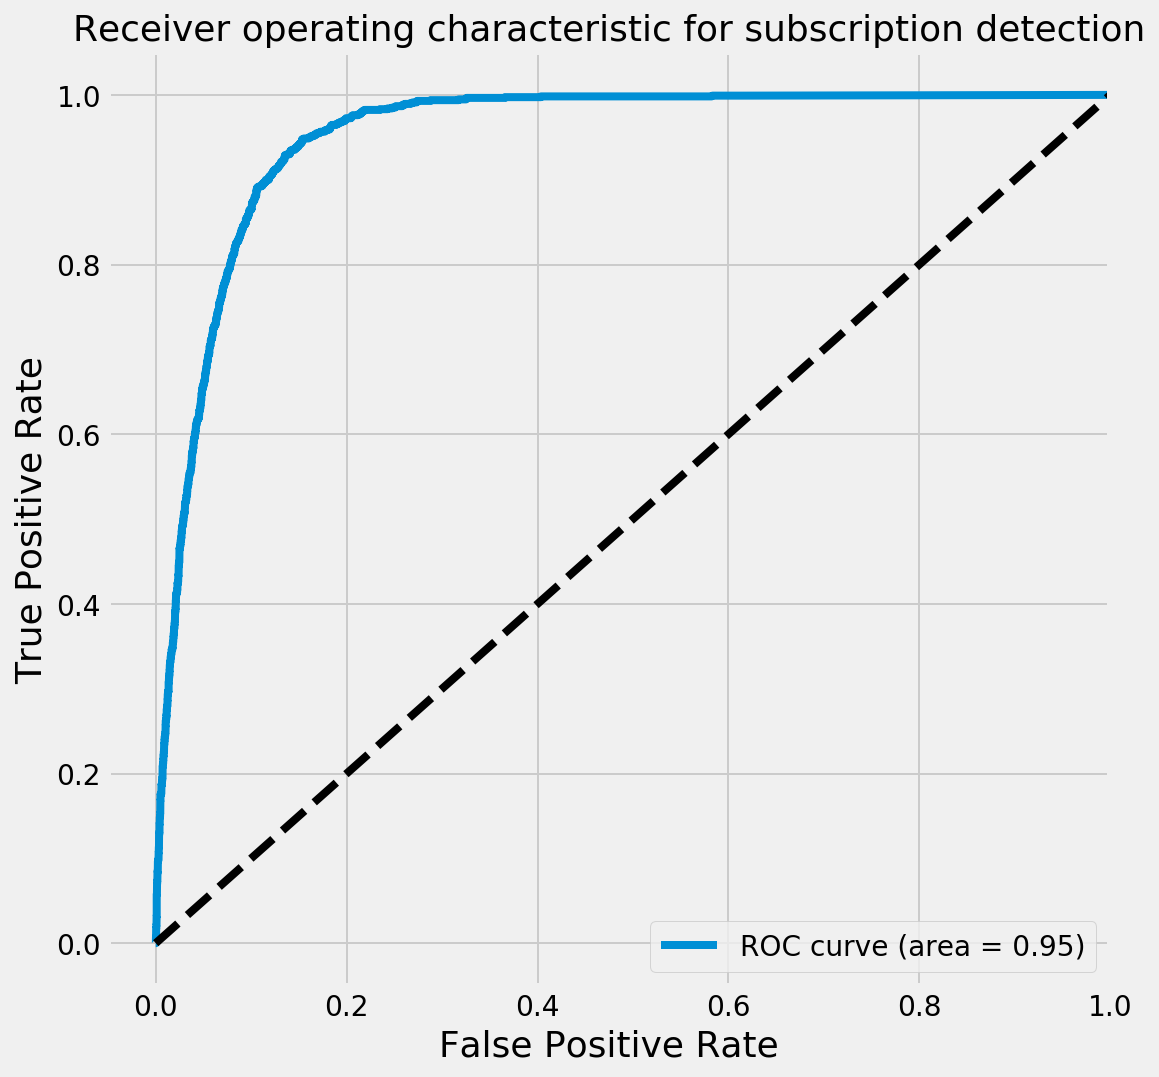

In [126]:
from sklearn.metrics import roc_curve, auc

# Plot the ROC base on 0.5 predicted probability threshold
adjust_threshold(pipe_rf2, 0.5)

# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(ys_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for subscription detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Feature Importancy Analysis

In [104]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train_smote, y_train_smote)

from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

# you will need to re-run the code to see the output.

<!-- http://127.0.0.1:7992/112365470352/ -->